In [44]:
#@title Imports
from tensorflow import keras
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
from google.colab import drive

from sklearn.utils import resample
from scipy import stats

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
tf.random.set_seed(42)

In [45]:
#@title Model
def build_resnet(input_shape, nb_classes, n_feature_maps = 64):
    x = keras.layers.Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)

    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)

    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*3, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)
     
    conv_y = keras.layers.Conv2D(n_feature_maps*3, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)
     
    conv_z = keras.layers.Conv2D(n_feature_maps*3, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*3, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)

    y = keras.layers.Add()([shortcut_y, conv_z])
    y = keras.layers.Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling2D()(y)
    out = keras.layers.Dense(nb_classes, activation='softmax')(full)

    return x, out

In [46]:
#@title Data download
drive.mount('/content/drive/')

!cp "/content/drive/MyDrive/boiled_data.csv" "/home/"
df = pd.read_csv('/home/boiled_data.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
#@title Downsampling
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

11    30720
10    30720
9     30720
5     30720
4     30720
3     30720
2     30720
1     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [48]:
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)

In [49]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [50]:
train = df1[(df1['subject'] != 'subject9') & (df1['subject'] != 'subject10')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((266295, 8), (69386, 8))

In [51]:
X_train = train.drop(['Activity', 'subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity', 'subject'],axis=1)
y_test = test['Activity']

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((266295, 6), (266295,), (69386, 6), (69386,))

In [52]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])

    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [53]:
X_train,y_train = create_dataset(X_train, y_train, 100, step=50)
X_test,y_test = create_dataset(X_test, y_test, 100, step=50)

X_train.shape, y_train.shape

((5324, 100, 6), (5324, 1))

In [54]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/modelDL.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1)]

nb_classes = len(label_map)

x , y = build_resnet(X_train.shape[1:], nb_classes)
model = keras.models.Model(inputs=x, outputs=y)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)

In [56]:
model_history = model.fit(X_train, y_train, epochs= 1000, validation_data=(X_test,y_test), callbacks=callbacks)

Epoch 1/1000
167/167 [==============================] - 47s 239ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.6234 - val_loss: 7.7354 - val_sparse_categorical_accuracy: 0.3189


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/1000
167/167 [==============================] - 37s 219ms/step - loss: 0.3167 - sparse_categorical_accuracy: 0.8888 - val_loss: 8.6448 - val_sparse_categorical_accuracy: 0.1905
Epoch 3/1000
167/167 [==============================] - 37s 220ms/step - loss: 0.2173 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.2305 - val_sparse_categorical_accuracy: 0.9040
Epoch 4/1000
167/167 [==============================] - 37s 220ms/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.3144 - val_sparse_categorical_accuracy: 0.8882
Epoch 5/1000
167/167 [==============================] - 37s 221ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.9587 - val_loss: 0.3010 - val_sparse_categorical_accuracy: 0.8651
Epoch 6/1000
167/167 [==============================] - 37s 220ms/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.2606 - val_sparse_categorical_accuracy: 0.9062
Epoch 7/1000
167/167 [==============================] - 37s 221ms/step - lo

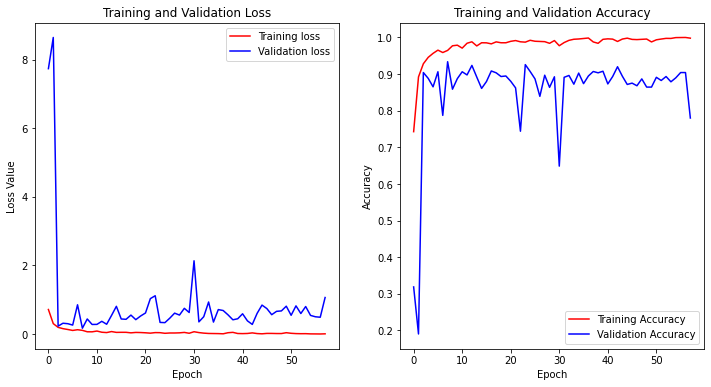

In [57]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
model = keras.models.load_model('/content/drive/MyDrive/modelDL.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

44/44 [==============================] - 2s 53ms/step - loss: 0.1691 - sparse_categorical_accuracy: 0.9336
Train accuracy 96.15 %
Train loss 0.11912021040916443
Test accuracy 93.36 %
Test loss 0.16912774741649628


In [59]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)
pred = pred.reshape(-1,1)

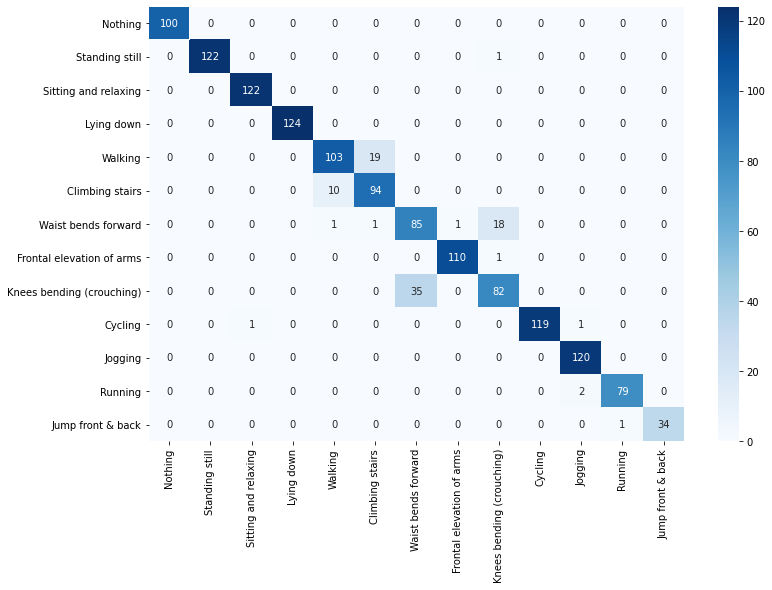

In [60]:
plt.figure(figsize=(12,8))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d", cmap="Blues")
plt.show()